In [1]:
# naively implementing CNOT on dual-rail
from qutip import tensor, basis, Qobj
import numpy as np

In [2]:
# create an operator using qutip
zero = basis(2, 0)  # |0>
one = basis(2, 1)  # |1>

# CNOT on dual-rail qubits
# found by substituting:
# |00>L = |0101>, |01>L = |0110>, |10>L = |1001>, |11>L = |1010> into CNOT operator

# op = |0101><0101| + |0110><0110| + |1001><1010| + |1010><1001|
op = (
    tensor(zero, one, zero, one) * tensor(zero, one, zero, one).dag()
    + tensor(zero, one, one, zero) * tensor(zero, one, one, zero).dag()
    + tensor(one, zero, zero, one) * tensor(one, zero, one, zero).dag()
    + tensor(one, zero, one, zero) * tensor(one, zero, zero, one).dag()
)
# Convert to a NumPy array
op_np = np.array(op)

# NOTE this is a particular choice, but could be done differently if makes the gate easier to implement
# for example, if going to stop after detecting a loss, don't necessarily need to preserve the state

# Check for columns with no specified kets
defined_columns = [5, 6, 9, 10]  # indices of the columns with explicit terms
for i in range(op.shape[1]):
    if i not in defined_columns and np.sum(op_np[:, i]) == 0:
        op_np[i, i] = 1

# Convert back to a Qobj
op_corrected = Qobj(op_np)

print(np.real(op_corrected))

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


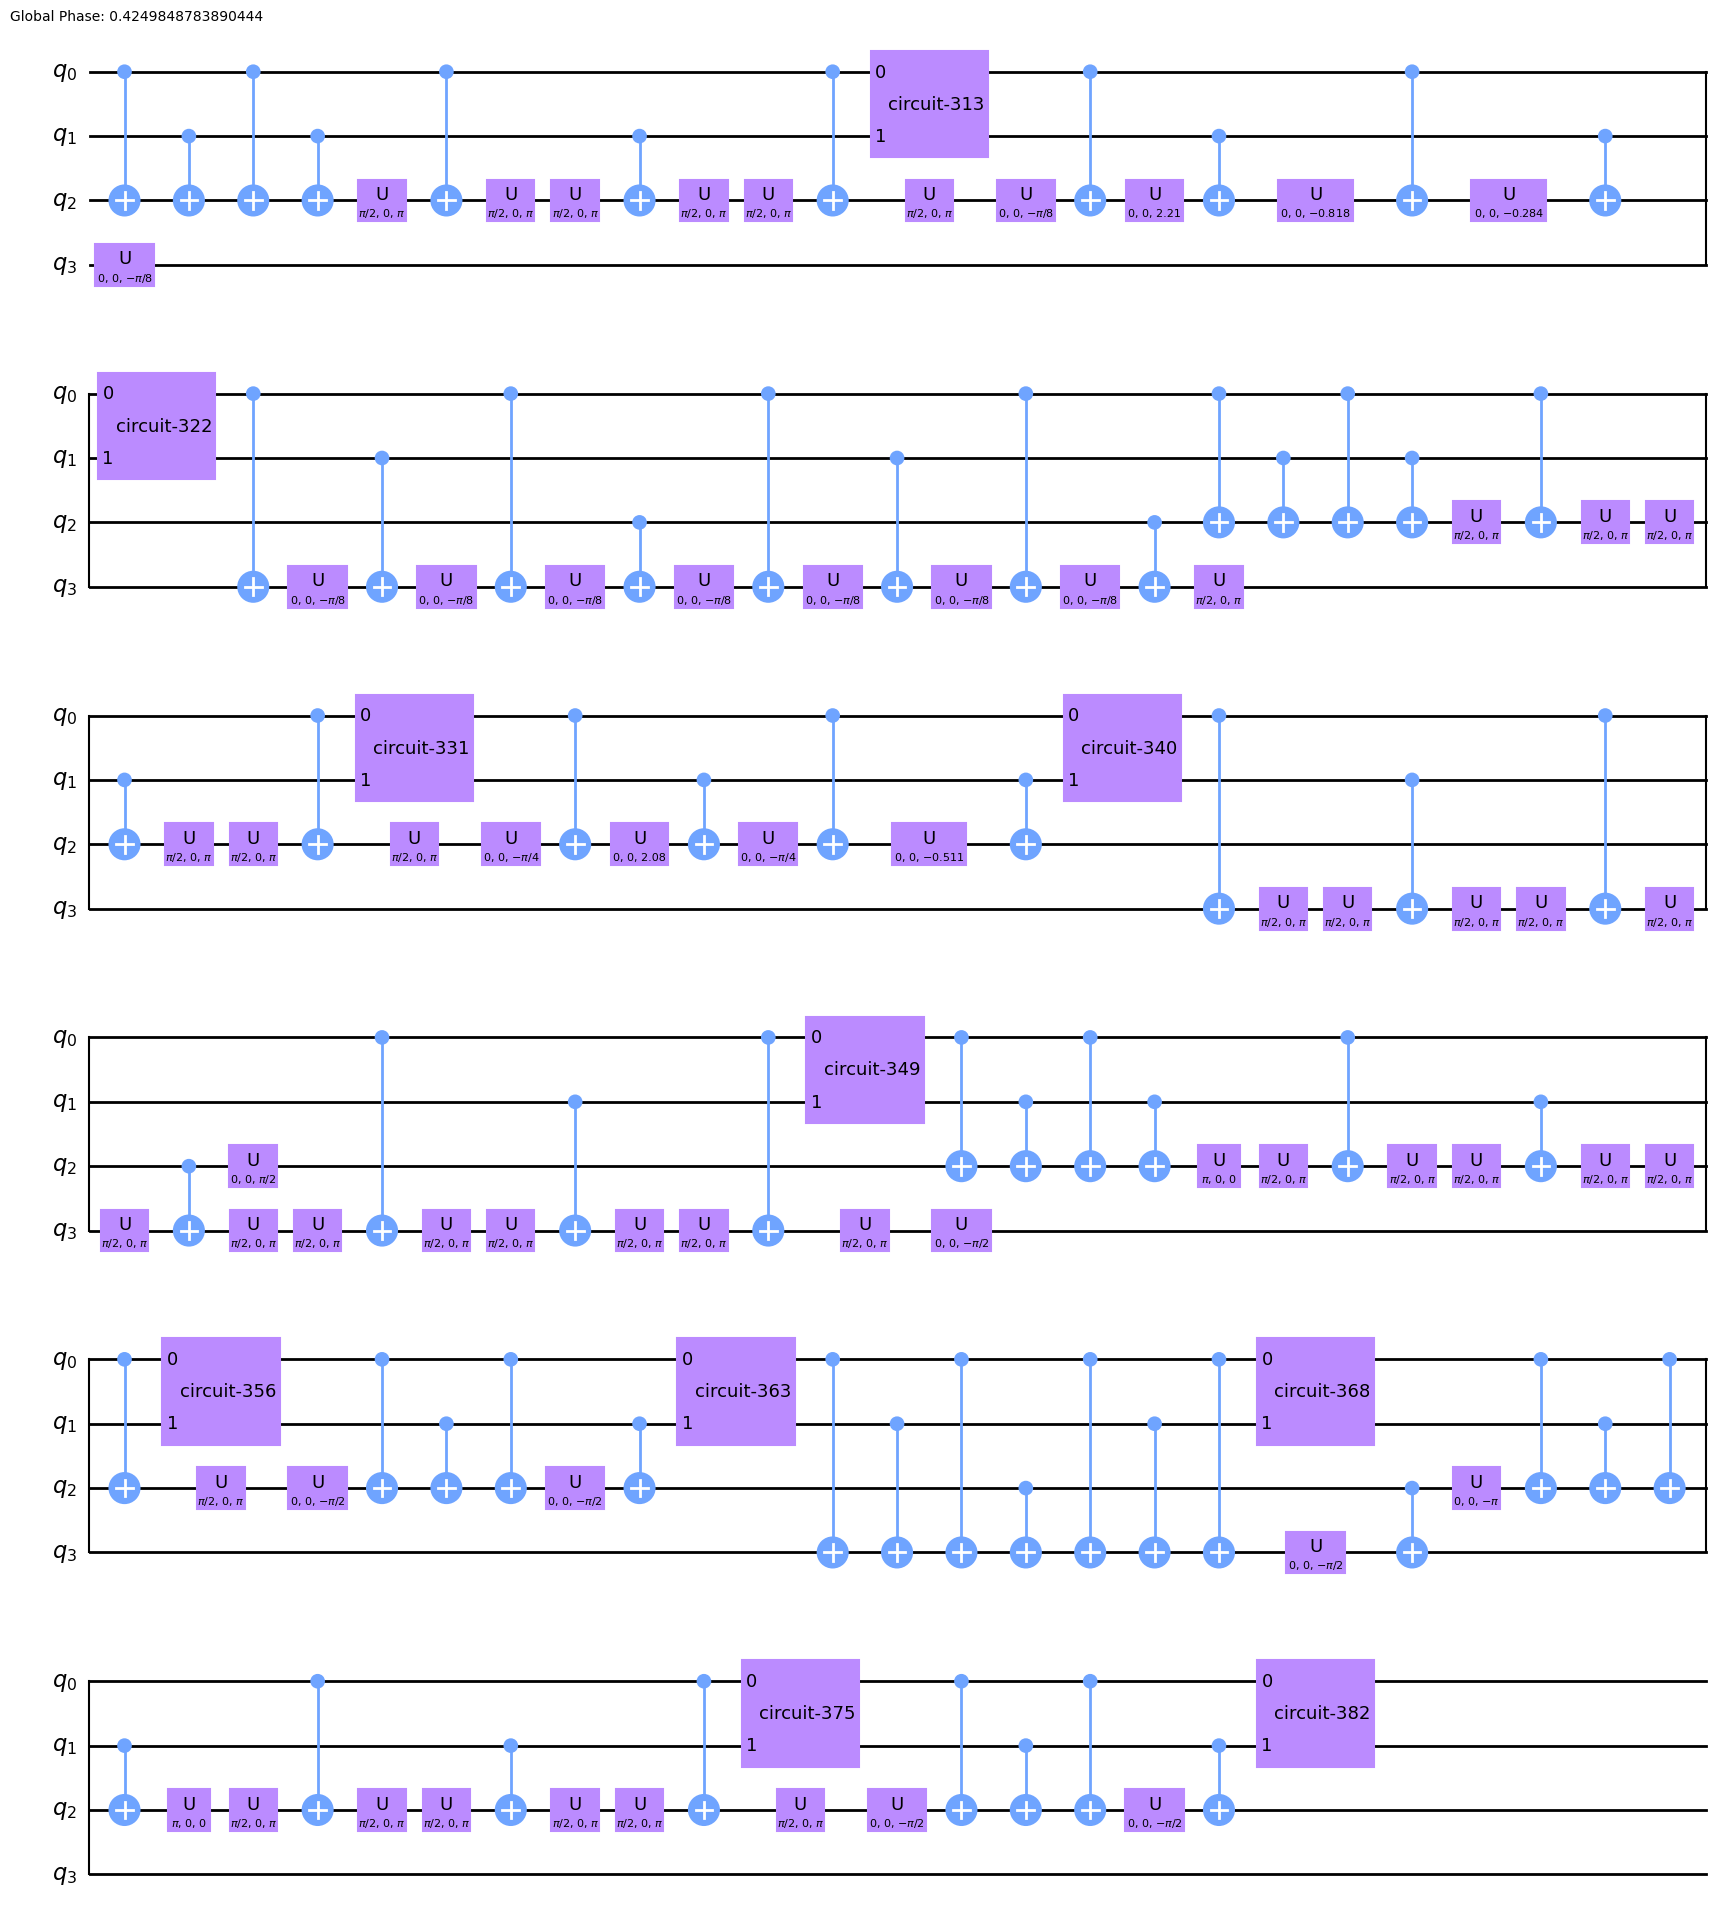

In [3]:
from qiskit import QuantumCircuit, transpile

qc = QuantumCircuit(4)

from qiskit.extensions import UnitaryGate

qc.append(UnitaryGate(op_corrected), [0, 1, 2, 3])
# qc = transpile(qc, basis_gates=['u', 'cx', 'ccx'])
qc.decompose().draw("mpl")

In [11]:
op = (
    tensor(zero, one, zero, one) * tensor(zero, one, zero, one).dag()
    + tensor(zero, one, one, zero) * tensor(zero, one, one, zero).dag()
    + tensor(one, zero, zero, one) * tensor(one, zero, one, zero).dag()
    + tensor(one, zero, one, zero) * tensor(one, zero, zero, one).dag()
)

from quantum_logical.unitary_util import ImplicitUnitaryGate

gate = ImplicitUnitaryGate(op)

In [13]:
qc = QuantumCircuit(4)
qc.append(gate, [0, 1, 2, 3])
qc.decompose().draw("mpl")